In [1]:
import pandas as pd
import numpy as np
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer

# Reading News and Gold datas


In [ ]:
from datetime import datetime

#load gold price and news data
gold_data = pd.read_excel ("Daily.xlsx")[['Date','Close']]
news_data = pd.read_excel ("News.xlsx")[['Main Content','Published Date']]

# news_data['Published Date'] = pd.to_datetime(news_data['Published Date'], errors='coerce')
# news_data['Published Date'] = news_data['Published Date'].dt.tz_localize(None)
# news_data['Published Date'] = news_data['Published Date'].dt.tz_convert('UTC')
# news_data['Date'] = news_data['Published Date'].dt.strftime('%Y-%m-%d')

news_data['Date'] = [datetime.fromisoformat(ts).date().strftime('%Y-%m-%d') for ts in news_data['Published Date']]


# news_data['Date'] = pd.to_datetime(news_data['Published Date']).dt.normalize().dt.strftime('%Y-%m-%d')

news_data = news_data[['Date','Main Content']]

gold_data['Date'] = pd.to_datetime(gold_data['Date']).dt.strftime('%Y-%m-%d')

news_data.head()

,Date,Main Content
0,2018-05-15,"“The combination of rising borrowing costs, tr..."
1,2018-05-22,A widely-followed section of the US Treasury y...
2,2018-05-22,China has all the reasons to wish for a second...
3,2018-05-22,"One-month risk reversal for the EUR/USD, a gau..."
4,2018-05-22,EUR/JPY consolidates gains in the Asian sessio...


## Calculate daily gold price change

In [48]:
gold_data['Change'] = gold_data['Close'].pct_change() * 100


gold_data.tail()

,Date,Close,Change
5320,2025-02-27,2877.12,-1.337055
5321,2025-02-28,2859.06,-0.627711
5322,2025-03-03,2892.99,1.186754
5323,2025-03-04,2917.70,0.854134
5324,2025-03-05,2917.18,-0.017822


### Merge two dataframe

In [62]:
# Merge gold_data and news_data on the Date column
merged_data = pd.merge(gold_data, news_data, on='Date', how='outer')

# Sort by Date for better readability
merged_data = merged_data.dropna()

merged_data.describe()

,Close,Change
count,107457.000000,107457.000000
mean,1528.158701,0.036059
std,251.158024,0.931503
min,1173.930000,-5.673675
25%,1287.390000,-0.397576
50%,1498.640000,0.068476
75%,1744.240000,0.526906
max,2063.250000,4.698562


## Classify Price Change

In [50]:
merged_data['Change'] = merged_data['Change'].apply(np.ceil) 
merged_data.describe()

,Close,Change
count,107457.000000,107457.000000
mean,1528.158701,0.529040
std,251.158024,0.962315
min,1173.930000,-5.000000
25%,1287.390000,0.000000
50%,1498.640000,1.000000
75%,1744.240000,1.000000
max,2063.250000,5.000000


In [63]:
targets = np.arange(-5, 5.5, 1).tolist() 


def classify_to_nearest(value, target_values):
    return target_values[np.argmin(np.abs(np.array(target_values) - value))]
#     return target_values[np.argmin(np.abs(target_values - value))]

# Example values
values = merged_data['Change']

# Classify all values
merged_data['Change'] = [classify_to_nearest(v, targets) for v in values]
merged_data['Change'] = [str(element) for element in merged_data['Change']]

merged_data.head()

,Date,Close,Change,Main Content
3567,2018-05-15,1290.77,-2.0,"“The combination of rising borrowing costs, tr..."
3572,2018-05-22,1291.02,0.0,A widely-followed section of the US Treasury y...
3573,2018-05-22,1291.02,0.0,China has all the reasons to wish for a second...
3574,2018-05-22,1291.02,0.0,"One-month risk reversal for the EUR/USD, a gau..."
3575,2018-05-22,1291.02,0.0,EUR/JPY consolidates gains in the Asian sessio...


## Find Most Important keywords

In [64]:

documents = merged_data['Main Content']

vectorizer = TfidfVectorizer(stop_words="english")

X = vectorizer.fit_transform(documents)

feature_names = vectorizer.get_feature_names_out()

def extract_top_keywords(doc_id, X, feature_names, top_n=1):
    """Extract top N keywords based on TF-IDF scores for a given document"""
    feature_index = X[doc_id].nonzero()[1]
    tfidf_scores = zip(feature_index, [X[doc_id, idx] for idx in feature_index])
    sorted_keywords = sorted(tfidf_scores, key=lambda x: x[1], reverse=True)[:top_n]
    return [feature_names[idx] for idx, _ in sorted_keywords]


keywords = []

for i in range(len(documents)):
    keywords.append(extract_top_keywords(i, X, feature_names))
#     print(f"Top keywords for Document {i + 1}: {extract_top_keywords(i, X, feature_names)}")

merged_data['Keywords'] = keywords
merged_data

,Date,Close,Change,Main Content,Keywords
3567,2018-05-15,1290.77,-2.0,"“The combination of rising borrowing costs, tr...",[costs]
3572,2018-05-22,1291.02,0.0,A widely-followed section of the US Treasury y...,[yield]
3573,2018-05-22,1291.02,0.0,China has all the reasons to wish for a second...,[trump]
3574,2018-05-22,1291.02,0.0,"One-month risk reversal for the EUR/USD, a gau...",[inside]
3575,2018-05-22,1291.02,0.0,EUR/JPY consolidates gains in the Asian sessio...,[133]
...,...,...,...,...,...
111227,2021-06-21,1783.25,1.0,The upside break of the falling channel seen i...,[147]
111228,2021-06-21,1783.25,1.0,Canada’s Foreign Minister Chrystia Freeland s...,[hominem]
111229,2021-06-21,1783.25,1.0,The US President Trump has again singled out G...,[nato]
111230,2021-06-21,1783.25,1.0,"The USD/CAD pair trades at 1.2960, having a hi...",[2999]


## convert keywords to number

In [65]:
from sklearn.preprocessing import LabelEncoder
import numpy as np


keywords = merged_data['Keywords']

# Flatten the list
flat_keywords = [word for group in keywords for word in group]

# Apply Label Encoding
encoder = LabelEncoder()
encoded_keywords = encoder.fit_transform(flat_keywords)
encoded_keywords
# Convert back into original structure with encoded values
encoded_groups = [[encoded_keywords[flat_keywords.index(word)] for word in group] for group in keywords]

df = merged_data[["Change"]]
df['Keywords'] = encoded_groups
df.head()

C:\Users\Amir\AppData\Local\Temp\ipykernel_14904\109953907.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Keywords'] = encoded_groups


,Change,Keywords
3567,-2.0,[8210]
3572,0.0,[18069]
3573,0.0,[17043]
3574,0.0,[11244]
3575,0.0,[905]


# First Approach
## -------------------------------

In [66]:
df['Keywords'] = df['Keywords'].apply(lambda x: x[0])
df['Keywords']

C:\Users\Amir\AppData\Local\Temp\ipykernel_14904\1031029926.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Keywords'] = df['Keywords'].apply(lambda x: x[0])


3567       8210
3572      18069
3573      17043
3574      11244
3575        905
          ...  
111227     1033
111228    10820
111229    12876
111230     2382
111231     4635
Name: Keywords, Length: 107457, dtype: int64

In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split


X = df['Keywords'].array.reshape(-1, 1)
y = df['Change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

clf = RandomForestClassifier()
clf.fit(X_train, y_train)


RandomForestClassifier()

In [68]:
y_pred = clf.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


classes = np.arange(-5, 5.5, 1).tolist() 
  
# classes = [-3.,-2.,-1.,0.,1.,2.,4.] 

 # Step size of 0.5
classes = [str(element) for element in classes]


report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)

<Figure size 1000x600 with 0 Axes>

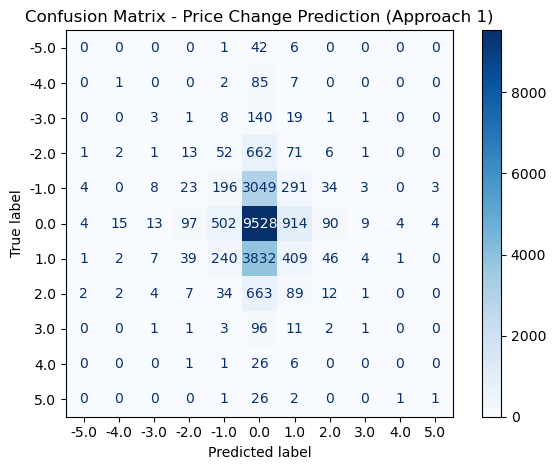

In [70]:

# Plot confusion matrix
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix - Price Change Prediction (Approach 1)')
plt.grid(False)
plt.tight_layout()
plt.show()



In [71]:
# Return evaluation report
print(report)

              precision    recall  f1-score   support

        -1.0       0.19      0.05      0.08      3611
        -2.0       0.07      0.02      0.03       809
        -3.0       0.08      0.02      0.03       173
        -4.0       0.05      0.01      0.02        95
        -5.0       0.00      0.00      0.00        49
         0.0       0.52      0.85      0.65     11180
         1.0       0.22      0.09      0.13      4581
         2.0       0.06      0.01      0.02       814
         3.0       0.05      0.01      0.01       115
         4.0       0.00      0.00      0.00        34
         5.0       0.12      0.03      0.05        31

    accuracy                           0.47     21492
   macro avg       0.12      0.10      0.09     21492
weighted avg       0.36      0.47      0.38     21492



# Second Approach
## ----------------------------------

In [80]:
# from sklearn.cluster import KMeans
# from gensim.models import Word2Vec

# # model = Word2Vec(sentences=df['Keywords'], vector_size=100, window=5, min_count=1)
# # keyword_vectors = [model.wv[word] for word in model.wv.index_to_key]

# kmeans = KMeans(n_clusters=10)
# kmeans.fit(df['Keywords'].array.reshape(-1, 1))

# # Now, map each keyword to a cluster
# def keywords_to_cluster_counts(keywords):
#     cluster_ids = kmeans.predict([model.wv[word] for word in keywords if word in model.wv])
#     counts = [0] * 20
#     for cid in cluster_ids:
#         counts[cid] += 1
#     return counts
# f = pd.DataFrame(data={'kw' : encoded_groups}) 

# X = f['kw'].apply(keywords_to_cluster_counts).tolist()


In [113]:
# from sklearn.cluster import KMeans


X = df[['Keywords']]
y = df[['Change']]

kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

df.describe()

D:\Software\Anacoda\Setup\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\Amir\AppData\Local\Temp\ipykernel_14904\1686312316.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cluster'] = kmeans.fit_predict(X)


,Keywords,Cluster
count,107457.000000,107457.000000
mean,9502.215258,1.851541
std,4965.668490,1.495385
min,0.000000,0.000000
25%,6384.000000,0.000000
50%,9674.000000,2.000000
75%,13492.000000,3.000000
max,18178.000000,4.000000


In [118]:
from scipy.stats import mode


labels = np.zeros_like(df['Cluster'])
for i in range(4):  # for each cluster
    mask = (df['Cluster'] == i)
    labels[mask] = y[mask].mode()

# Confusion matrix and report
cm = confusion_matrix(y_true, labels)
report = classification_report(y_true, labels)

print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", report)

ValueError: invalid literal for int() with base 10: '0.0'

In [109]:
classes = np.arange(1, 4.1, 1).tolist() 
  
classes = [str(element) for element in classes]

X = df['Keywords'].array.reshape(-1, 1)
y = df['Change']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

y_pred = clf.predict(X_test)
report2 = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred, labels=classes)


<Figure size 1000x600 with 0 Axes>

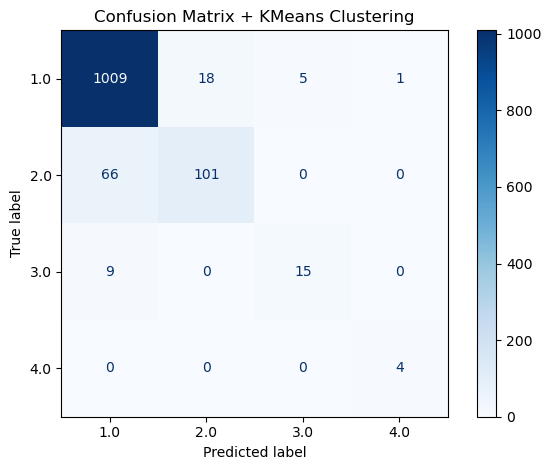

In [110]:
plt.figure(figsize=(10, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix + KMeans Clustering')
plt.grid(False)
plt.tight_layout()
plt.show()



In [119]:
print(report2)

              precision    recall  f1-score   support

        -1.0       0.57      0.17      0.26      3559
        -2.0       0.60      0.14      0.23       759
        -3.0       0.49      0.11      0.17       190
        -4.0       0.43      0.11      0.17        92
        -5.0       0.71      0.08      0.15        60
         0.0       0.57      0.93      0.71     11226
         1.0       0.58      0.22      0.32      4615
         2.0       0.57      0.13      0.21       793
         3.0       0.58      0.11      0.19       135
         4.0       0.50      0.14      0.22        29
         5.0       0.58      0.21      0.30        34

    accuracy                           0.57     21492
   macro avg       0.56      0.21      0.27     21492
weighted avg       0.57      0.57      0.50     21492



## convert keywords to number

In [191]:
def string_to_number(ls):
    
    numbers = []
    
    for s in ls:
        if s.isdigit():
            num = np.float32(s)
            numbers.append(num)
            continue

        num = sum(ord(c) for c in s)
        numbers.append(np.float32(num))
        
    if len(numbers) < 10:
        while (len(numbers)) != 10:
            numbers.append(0.0)
    
    return numbers





In [192]:
merged_data["Keywords"] = merged_data['Keywords'].apply(string_to_number)
merged_data.head

<bound method NDFrame.head of             Date    Close  Change  \
4678  2022-09-01  1697.55    -0.0   
4707  2022-10-12  1673.12     1.0   
4765  2023-01-04  1854.68     1.0   
4786  2023-02-02  1912.60    -1.0   
4792  2023-02-10  1865.35     1.0   
...          ...      ...     ...   
5856  2025-03-05  2917.18    -0.0   
5857  2025-03-05  2917.18    -0.0   
5858  2025-03-05  2917.18    -0.0   
5859  2025-03-05  2917.18    -0.0   
5860  2025-03-05  2917.18    -0.0   

                                           Main Content  \
4678  Helen Barth / UnsplashPack up the excavation k...   
4707  Zlaťáky.cz / UnsplashInvestors are feeling anx...   
4765  UnsplashGold has been on a rampage recently, a...   
4786  Peter Olexa / UnsplashGold prices climb to a 9...   
4792  Infrarate.com / UnsplashThe yellow metal is re...   
...                                                 ...   
5856  The broad market exchange-traded fund SPDR S&P...   
5857  Key points:Spot gold down 0.1% at $2,913.79 an.

# Predict Gold price changing

In [94]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report

In [228]:
X = merged_data['Keywords']
df = pd.DataFrame(X)
X = pd.DataFrame(df["Keywords"].to_list())
X[0:5]

,0,1,2,3,4,5,6,7,8,9
0,531.0,2022.0,529.0,1293.0,328.0,543.0,318.0,224.0,524.0,1074.0
1,520.0,1883.0,1192.0,428.0,1137.0,221.0,416.0,531.0,1004.0,435.0
2,530.0,779.0,733.0,338.0,551.0,626.0,644.0,1300.0,865.0,615.0
3,448.0,532.0,746.0,737.0,637.0,324.0,1300.0,537.0,1067.0,1084.0
4,532.0,433.0,956.0,650.0,772.0,975.0,646.0,881.0,1003.0,331.0


In [229]:
y = np.asarray(merged_data['Change'])
y [0:10]

array([-0.,  1.,  1., -1.,  1.,  1., -0.,  1.,  2., -1.])

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [231]:
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 



SVC()

In [236]:
yhat = clf.predict(X_test)
yhat [0:5]
y_test[0:5]

array([-0.,  1., -0.,  1.,  2.])

In [233]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [234]:
%matplotlib inline 
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

D:\Software\Anacoda\Setup\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Software\Anacoda\Setup\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
D:\Software\Anacoda\Setup\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

        -2.0       0.00      0.00      0.00         3
        -1.0       0.00      0.00      0.00        20
        -0.0       0.15      0.04      0.06        53
         1.0       0.42      0.92      0.57        74
         2.0       1.00      0.04      0.07        27

    accuracy                           0.40       177
   macro avg       0.31      0.20      0.14       177
weighted avg       0.37      0.40      0.27       177

Confusion matrix, without normalization
[[1 0]
 [0 0]]


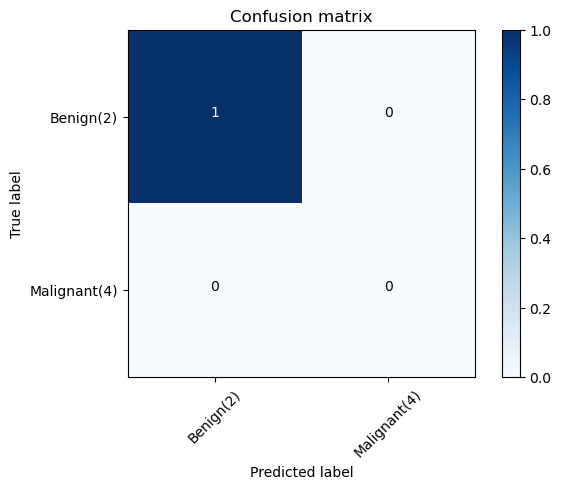

In [226]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[2,4])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Benign(2)','Malignant(4)'],normalize= False,  title='Confusion matrix')

In [235]:
from sklearn.metrics import f1_score
f1_score(y_test, yhat, average='weighted') 

0.2465167578274473